In [2]:
import numpy as np

from utils.mobility_utils import generate_mobility
from utils.radio_utils import compute_sinr_dl

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

In [3]:
class CellularEnv(gym.Env):
    def __init__(self,
                 n_users=5,
                 n_antennas=13,
                 radios_per_user=2,
                 sim_time=300,
                 time_step=0.5,
                 map_limit=1000,
                 seed=0,
                 reward_mode="proportional_fairness"):
        super(CellularEnv, self).__init__()

        # Definition of the environment parameters
        self.n_users = n_users
        self.n_antennas = n_antennas
        self.radios_per_user = radios_per_user
        self.sim_time = sim_time
        self.time_step = time_step
        self.map_limit = map_limit
        self.max_steps = int(sim_time / time_step)
        self.current_step = 0

        self.reward_mode = reward_mode

        self.seed(seed)
        self.prev_reward = None
        self.reward_history = []

        # Definition of the network parameters
        self.alpha_loss = 4
        self.p_macro = 40
        self.p_femto = 0.1
        self.n_macro = 3
        self.n_femto = n_antennas - self.n_macro
        self.macro_bw = 20e6
        self.femto_bw = 1e9
        self.noise = 2.5e-14
        self.b = 1 * np.sqrt(2 / np.pi)

        # Set the observation space: [user_positions (x,y) | bs_loads ]
        # This defines how does the agent observe the environment
        obs_low = np.array([0] * (2 * self.n_users) + [0] * self.n_antennas, dtype=np.float32)
        obs_high = np.array([self.map_limit] * (2 * self.n_users) + [self.n_users] * self.n_antennas, dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # Set the action space: for each user, pick radios_per_user base stations (by index)
        # This defines all the possible actions the agent can take
        self.action_space = spaces.MultiDiscrete([self.n_antennas] * self.n_users * self.radios_per_user)

        # Internal simulation state variables
        self.base_stations = None  # will contain the positions of the base stations
        self.user_positions = None  # will contain the positions of the users
        self.bs_user_count = None  # will contain the number of users per base station
        self.throughputs = None  # will contain the throughput of each user

        # Mobility traces 
        self.sim_times = np.arange(0, self.sim_time + self.time_step, self.time_step)
        self.mobility_traces = None  # will contain the positions of the users over time

        # Initialize the environment
        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)

    def reset(self, seed=None, options=None):
        """
        Resets the environment to an initial state and returns the initial observation.
        """
        if seed is not None:
            self.seed(seed)

        # Each episode starts in the first time step (t=0)
        self.current_step = 0
        self.prev_reward = None
        self.reward_history = []

        # Reinitialize base stations: positions randomly over the map
        # Create an array full of zeros with as many row as antennas and 3 columns (x, y, power)
        self.base_stations = np.zeros((self.n_antennas, 3))
        # Macro cells are filled with random positions and power defined in the init
        self.base_stations[:self.n_macro, 0] = np.random.uniform(0, self.map_limit, self.n_macro)
        self.base_stations[:self.n_macro, 1] = np.random.uniform(0, self.map_limit, self.n_macro)
        self.base_stations[:self.n_macro, 2] = self.p_macro
        # Femto cells are filled with random positions and power defined in the init
        self.base_stations[self.n_macro:, 0] = np.random.uniform(0, self.map_limit, self.n_femto)
        self.base_stations[self.n_macro:, 1] = np.random.uniform(0, self.map_limit, self.n_femto)
        self.base_stations[self.n_macro:, 2] = self.p_femto

        # Generate real mobility for each user
        sim_input = {
            'V_POSITION_X_INTERVAL': [0, self.map_limit],
            'V_POSITION_Y_INTERVAL': [0, self.map_limit],
            'V_SPEED_INTERVAL': [1, 10],
            'V_PAUSE_INTERVAL': [0, 3],
            'V_WALK_INTERVAL': [30.0, 60.0],
            'V_DIRECTION_INTERVAL': [-180, 180],
            'SIMULATION_TIME': self.sim_time,
            'NB_NODES': self.n_users
        }
        s_mobility = generate_mobility(sim_input)

        # Interpolate user positions for each timestep
        self.mobility_traces = np.zeros((self.n_users, len(self.sim_times), 2))
        for u, node in enumerate(s_mobility["VS_NODE"]):
            x = np.interp(self.sim_times, node["V_TIME"], node["V_POSITION_X"])
            y = np.interp(self.sim_times, node["V_TIME"], node["V_POSITION_Y"])
            self.mobility_traces[u, :, 0] = x
            self.mobility_traces[u, :, 1] = y

        self.user_positions = self.mobility_traces[:, 0, :]
        self.bs_user_count = np.zeros(self.n_antennas, dtype=int)
        self.throughputs = np.zeros(self.n_users, dtype=float)

        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        """
        Executes one time step within the environment given the action.
        """
        done = False
        info = {}

        # Update user positions (mobility)
        if self.current_step < len(self.sim_times):
            self.user_positions = self.mobility_traces[:, self.current_step, :]
        else:
            # Just hold last positions
            pass

        # Action: (n_users * radios_per_user, ), reshape
        associations = np.array(action).reshape((self.n_users, self.radios_per_user))

        # Reset per-BS user counts
        self.bs_user_count = np.zeros(self.n_antennas, dtype=int)
        user_bs_sets = [set() for _ in range(self.n_antennas)]
        # For each user, increment BS count for each association
        for u in range(self.n_users):
            for radio in range(self.radios_per_user):
                bs_idx = associations[u, radio]
                # Avoid duplicates: only count once per user per BS
                if u not in user_bs_sets[bs_idx]:
                    self.bs_user_count[bs_idx] += 1
                    user_bs_sets[bs_idx].add(u)

        # Throughput calculation
        self.throughputs = np.zeros(self.n_users, dtype=float)
        for u in range(self.n_users):
            user_rate = 0
            user_pos = self.user_positions[u]
            for radio in range(self.radios_per_user):
                bs_idx = associations[u, radio]
                if bs_idx >= self.n_antennas:
                    continue
                sinr_db = compute_sinr_dl(
                    user_pos,
                    self.base_stations,
                    bs_idx,
                    self.alpha_loss,
                    self.p_macro,
                    self.p_femto,
                    self.n_macro,
                    self.noise,
                    self.b
                )
                sinr_linear = 10 ** (sinr_db / 10)
                is_macro = bs_idx < self.n_macro
                bw = self.macro_bw if is_macro else self.femto_bw
                rate = (bw / max(self.bs_user_count[bs_idx], 1)) * np.log2(1 + sinr_linear)
                user_rate += rate
            self.throughputs[u] = user_rate

        # Reward: proportional fairness 
        reward = self.compute_reward(mode=self.reward_mode)
        self.reward_history.append(reward)

        # Next observation 
        obs = self._get_obs()

        # Check for end of episode 
        self.current_step += 1
        terminated = False
        truncated= False
        if self.current_step >= self.max_steps:
            truncated = True

        return obs, reward, terminated, truncated, info

    def _get_obs(self):
        """
        Builds the observation vector: [user_positions | bs_user_count].
        """
        obs = np.concatenate([self.user_positions.flatten(), self.bs_user_count])
        return obs.astype(np.float32)
    
    def compute_reward(self, mode="proportional_fairness"):
        """
        Computes the reward based on throughput and fairness objectives.
        """
        eps = 1e-9
        thr = self.throughputs

        if mode == "mean":
            current_reward = np.mean(thr)
        elif mode == "min":
            current_reward = np.min(thr)
        elif mode == "proportional_fairness":
            current_reward = np.sum(np.log(thr + eps))
        elif mode == "jain":
            numerator = np.sum(thr) ** 2
            denominator = len(thr) * np.sum(thr ** 2) + eps
            current_reward = numerator / denominator
        elif mode == "combined":
            current_reward = np.mean(thr) + 0.01 * np.min(thr)
        elif mode == "conditional":
            if np.min(thr) < 1e6:
                current_reward = -10
            elif np.mean(thr) > 10e6:
                current_reward = 10
            else:
                current_reward = 0
        else:
            raise ValueError(f"Unsupported reward mode: {mode}")

        if self.prev_reward is None or self.current_step == 0:
            reward = 0
        else:
            reward = (current_reward - self.prev_reward) * 10
        self.prev_reward = current_reward
        return reward

In [ ]:
import scipy
mat = scipy.io.loadmat("nice_setup_Proteus.mat")
base_stations = mat["BaseStations"]
n_points = base_stations.shape[0]  # = 7

env = CellularEnv(
    n_users=5,
    n_antennas=n_points,
    radios_per_user=2,
    sim_time=300,
    time_step=0.5,
    map_limit=1000,
    seed=0,
    reward_mode="proportional_fairness"
)

# Crear el modelo PPO
model = PPO('MlpPolicy', env, verbose=1)

# Entrenar el agente
model.learn(total_timesteps=100000)

# Guardar modelo
model.save("ppo_cellular_multi_connectivity")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\algar\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 600      |
|    ep_rew_mean     | 64.7     |
| time/              |          |
|    fps             | 118      |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 600         |
|    ep_rew_mean          | 4.35        |
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 2           |
|    time_elapsed         | 37          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017345574 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -19.4       |
|    explained_variance   | 0.000525    |
|    learning_rate        | 0.

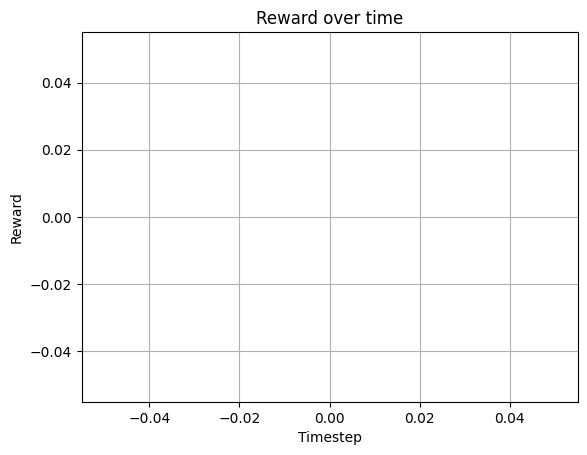

In [8]:
import matplotlib.pyplot as plt

plt.plot(env.reward_history)
plt.title("Reward over time")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

In [5]:
import numpy as np

model = PPO.load("ppo_cellular_multi_connectivity")
obs, info = env.reset()
total_reward = 0
episode_rewards = []

for step in range(1200):
    action, _states = model.predict(obs, deterministic=True)
    # Mostrar asociaciones de los usuarios (usuarios x radios)
    associations = np.array(action).reshape((env.n_users, env.radios_per_user))
    print(f"Step {step}: User associations (user x radio):\n{associations}")

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    # Check if episode finished (either by reaching max_steps or another criterion)
    if terminated or truncated:
        episode_rewards.append(total_reward)
        print(f"Episode finished. Reward: {total_reward}")
        obs, info = env.reset()
        total_reward = 0

Step 0: User associations (user x radio):
[[2 0]
 [1 2]
 [0 3]
 [1 6]
 [2 5]]
Step 1: User associations (user x radio):
[[2 0]
 [1 2]
 [0 3]
 [1 6]
 [2 5]]
Step 2: User associations (user x radio):
[[2 0]
 [1 2]
 [0 3]
 [1 6]
 [2 5]]
Step 3: User associations (user x radio):
[[2 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 4: User associations (user x radio):
[[2 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 5: User associations (user x radio):
[[2 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 6: User associations (user x radio):
[[2 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 7: User associations (user x radio):
[[6 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 8: User associations (user x radio):
[[6 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 9: User associations (user x radio):
[[6 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 10: User associations (user x radio):
[[6 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 11: User associations (user x radio):
[[6 0]
 [1 2]
 [0 3]
 [1 6]
 [2 1]]
Step 12: User associations (user x radio):
[[6 0]
 [1 2]
 [0 3

In [6]:
episode_rewards

[59.18801801013814, 24.299495975843826]